<a href="https://colab.research.google.com/github/VSurzhan/DL/blob/main/%D0%A1%D1%83%D1%80%D0%B6%D0%B0%D0%BD_HW_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 10

##### Автор: [Татьяна Гайнцева](https://www.linkedin.com/in/tgaintseva/), @atmyre

В этом задании вам предстоит построить автоэнкодер, который будет сжимать и восстанавливать лица людей. Мы будем работать с тем же датасетом LFW, что был на занятии.

## Подготовка датасета

Часть подготовки датасета полностью написана, изменять ее не нужно

Импортируем нужные библиотеки:

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Скачивание и подготовка данных

Скачиваем данные. Мы будем обучать автоэнкодер на датасете лиц людей [Labeled faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW). Ячейка ниже скачивает и распаковывает датасет:

In [ ]:
! wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz
os.system("tar xvzf tmp.tgz && rm tmp.tgz")

--2024-05-08 01:09:47--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

tmp.tgz             100%[===================>] 103.72M  2.05MB/s    in 61s     

2024-05-08 01:10:49 (1.69 MB/s) - ‘tmp.tgz’ saved [108761145/108761145]



0

Наши картинки скачались в папку lfw-deepfunneled. Давайте пройдемся по ней и соберем массив путей до картинок датасета:

In [ ]:
images = []

for dirpath, dirnames, filenames in os.walk('lfw-deepfunneled'):
    for fname in filenames:
        if fname.endswith(".jpg"):
            fpath = os.path.join(dirpath,fname)
            image = Image.open(fpath)
            images.append(image)

In [ ]:
len(images)

13233

Отрисуем несколько картинок, чтобы понять, с чем мы имеем дело:

In [ ]:
def plot_gallery(images, n_row=3, n_col=6, from_torch=False):
    """Helper function to plot a gallery of portraits"""

    # нужно поставить from_torch=True, если функция plot_gallery
    # вызывается для images типа torch.Tensor
    if from_torch:
        images = [x.data.numpy().transpose(1, 2, 0) for x in images]

    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])

        # убираем отрисовку координат
        plt.xticks(())
        plt.yticks(())

    plt.show()

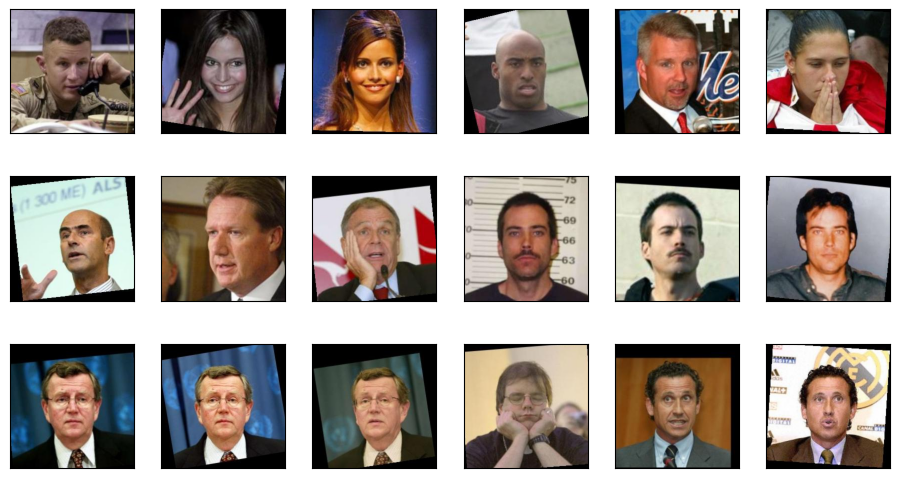

In [ ]:
plot_gallery(images)

Посмотрим, какие размерности у наших картинок:

In [ ]:
np.array(images[0]).shape

(250, 250, 3)

Создадим датасет Faces для работы с нашими данными:

In [ ]:
class Faces(Dataset):
    def __init__(self, faces):
        self.data = faces
        self.transform = transforms.Compose([
                                    transforms.CenterCrop((90, 90)),
                                    transforms.Resize((64, 64)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                    ])

    def __getitem__(self, index):

        x = self.data[index]
        return self.transform(x).float()

    def __len__(self):
        return len(self.data)

Создадим датасет и посмотрим на несколько картинок из него:

torch.Size([3, 64, 64])


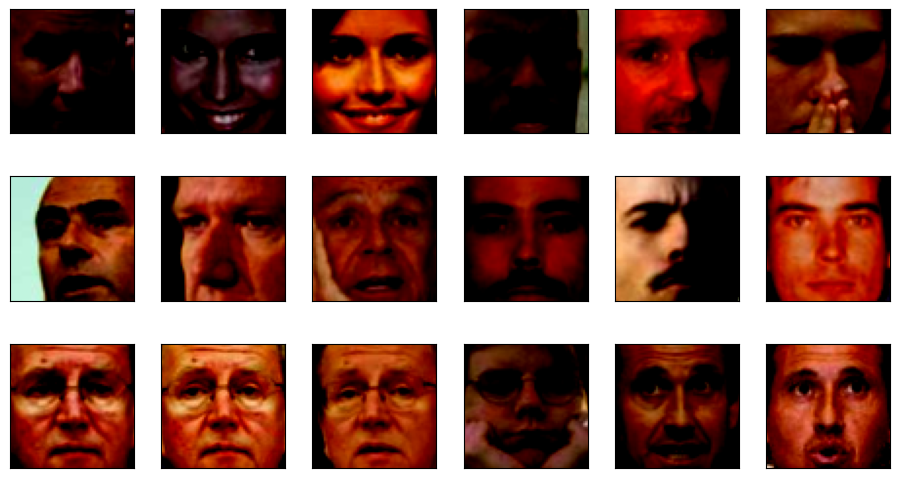

In [ ]:
dataset = Faces(images)

# dataset[0] — это вызов метода __getitem__(0)
img = dataset[0]

print(img.shape)

# отрисовываем несколько картинок
plot_gallery(dataset, from_torch=True)

Делим датасет на train/val и создаем даталоадеры:

In [ ]:
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size

g_cpu = torch.Generator().manual_seed(8888)
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size], generator=g_cpu)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False)

## Задание: Создание модели Vanilla AE

Ваша задача — реализовать класс атоэнкодера для данных. За основу можно взять класс сети для сегментации U-Net с прошлого домашнего задания. Так как автоэнкодер — это тоже encoder-decoder архитектура, нам понадобится внести лишь немного изменений:
- В U-Net был skip connection, в автоэнкодере его быть не должно;
- Обратите внимание на то, сколько карт активации должно быть в последнем слое сети.
- в середине сети не должно быть среднего слоя, как было в U-Net

Вы можете варьировать количества блоков/слоев и устройства блоков. Архитектура блока, как в предыдущем домашнем задании (conv -> bn -> relu -> maxpool) подойдет.

In [ ]:
def encoder_block(in_channels, out_channels, kernel_size, padding):
    '''
    блок, который принимает на вход карты активации с количеством каналов in_channels,
    и выдает на выход карты активации с количеством каналов out_channels
    kernel_size, padding — параметры conv слоев внутри блока
    '''
    block = nn.Sequential(
        # ВАШ КОД ТУТ
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

    return block

def decoder_block(in_channels, out_channels, kernel_size, padding):
    '''
    блок, который принимает на вход карты активации с количеством каналов in_channels,
    и выдает на выход карты активации с количеством каналов out_channels
    kernel_size, padding — параметры conv слоев внутри блока
    '''
    block = nn.Sequential(
        # ВАШ КОД ТУТ
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

    return block

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # добавьте несколько слоев encoder block
        # это блоки-составляющие энкодер-части сети
        # in -- 3 x 64 x 64
        self.encoder = nn.Sequential(
            encoder_block(3, 64, 3, 1),                                         # 64 x 32 x 32
            #nn.MaxPool2d(kernel_size=2),
            encoder_block(64, 128, 4, 1),
            #nn.MaxPool2d(kernel_size=2),
            encoder_block(128, 256, 4, 1),
            #nn.MaxPool2d(kernel_size=2),
            encoder_block(256, 512, 4, 0)
        )

        # добавьте несколько слоев decoder block
        # это блоки-составляющие декодер-части сети

        self.decoder = nn.Sequential(
            decoder_block(512, 256, 4, 0),
            decoder_block(256, 128, 4, 1),
            decoder_block(128, 64, 4, 1),
            decoder_block(64, 3, 4, 1)
        )

    def forward(self, x):


        # downsampling
        latent = self.encoder(x)

        # upsampling
        reconstruction = self.decoder(latent)

        return reconstruction


In [ ]:
random_tensor = torch.Tensor(np.random.random((32, 3, 64, 64)))
random_tensor.shape

torch.Size([32, 3, 64, 64])

In [ ]:
enc = encoder_block(3, 64, 3, 1)
out = enc(random_tensor)
out.shape

torch.Size([32, 64, 32, 32])

In [ ]:
pl = nn.MaxPool2d(kernel_size=2)
out2 = pl(out)
out2.shape

torch.Size([32, 64, 16, 16])

Ячейка ниже проверяет, что модель работает правильно:

In [ ]:
# проверка, что у модели есть обучаемые слои
model = Autoencoder()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
assert num_params > 10

# проверка, что модель собрана верно
random_tensor = torch.Tensor(np.random.random((32, 3, 64, 64)))
model = Autoencoder()
out = model(random_tensor)
print(out.shape)
assert out.shape == (32, 3, 64, 64), "неверный размер выхода модели"

# проверка, что у модели можно отцепить декодер и использовать его как
# отдельную модель
# если здесь возникла ошибка, убедитесь, что в вашей сети нет skip connection
random_tensor = torch.Tensor(np.random.random((32, 3, 64, 64)))
model = Autoencoder()
latent_shape = model.encoder(random_tensor).shape
latent = torch.Tensor(np.random.random(latent_shape))
out = model.decoder(latent)

torch.Size([32, 3, 64, 64])


### Сдача задания

Если обе ячейки отработали без ошибок, можно сдавать задание в первую задачу на Я.Контесте. Для этого нужно скопировать класс Autoencoder в нужное место в submission_template10.py и отправить submission_template10.py в Я.Контест.

## Обучение модели

Теперь вы можете обучить на данных созданную вами модель. Код для этого написан ниже. В процессе обучения вы будете видеть, насколько хорошо модель учится восстанавливать лица людей.

In [ ]:
from IPython.display import clear_output

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def train(model, opt, loss_fn, epochs, train_loader, val_loader):

    for epoch in range(epochs):
        # печатаем номер текущей эпохи
        print('* Epoch %d/%d' % (epoch+1, epochs))

        # 1. Обучаем сеть на картинках из train_loader
        model.train()  # train mode

        avg_train_loss = 0
        for i, X_batch in enumerate(train_loader):
            # переносим батч на GPU
            X_batch = X_batch.to(device)
            # получаем ответы сети на батч
            Y_pred = model(X_batch)

            # считаем лосс, делаем шаг оптимизации сети
            loss = loss_fn(Y_pred, X_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            avg_train_loss += loss / len(train_loader)

        # выводим средний лосс на тренировочной выборке за эпоху
        print('avg train loss: %f' % avg_train_loss)

        # 2. Тестируем сеть на картинках из val_loader
        model.eval()

        avg_val_loss = 0
        for i, X_batch in enumerate(val_loader):
            # переносим батч на GPU
            X_batch = X_batch.to(device)
            # получаем ответы сети на батч
            Y_pred = model(X_batch)
            # считаем лосс на батче
            loss = loss_fn(Y_pred, X_batch)

            avg_val_loss += loss / len(val_loader)

        # выводим средний лосс на валидационных данных
        print('avg val loss: %f' % avg_val_loss)


        # 3. Визуализируем ответы сети на шести картинках из валидационных данных

        # получаем один батч из data_val
        X_val = next(iter(val_loader))
        # получаем ответ сети на картинки из батча
        Y_pred = model(X_val.to(device))
        Y_hat = Y_pred.detach().cpu().numpy()
        Y_hat = np.argmax(Y_hat, axis=1)

        # удаляем предыдущую визуализацию
        clear_output(wait=True)

        _, axes = plt.subplots(2, 6, figsize=(6*4, 2*4))
        for k in range(6):
            # отрисовываем 6 картинок, поданных на вход сети
            # картинки нормализованы, поэтому могут выглядеть непривычно
            axes[0][k].imshow(denorm(X_val[k].data.cpu().numpy()).transpose(1, 2, 0), aspect='auto')
            axes[0][k].title.set_text('Input')

            # отрисовываем ответы сети для каждого из четырех классов сегментации в отдельности
            axes[1][k].imshow(denorm(Y_pred[k].data.cpu().numpy()).transpose(1, 2, 0), aspect='auto')
            axes[1][k].title.set_text('Output')
        plt.suptitle('%d / %d - val loss: %f' % (epoch+1, epochs, avg_val_loss))
        plt.show()

In [ ]:
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

train(autoencoder, optimizer, criterion, 10, train_loader, val_loader)